In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from statsmodels.graphics.tsaplots import plot_acf
import sklearn.metrics as metrics
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from matplotlib.widgets import Slider, Button, RadioButtons
from fastai.callbacks import *
from fastai.basic_train import Learner, LearnerCallback

In [3]:
import pickle

In [4]:
from forecasting import get_metrics

In [5]:
path = Path("data/LFP_Prediction/NewExperimentalData")

In [6]:
path.ls()

[PosixPath('data/LFP_Prediction/NewExperimentalData/trace_one_labels.csv'),
 PosixPath('data/LFP_Prediction/NewExperimentalData/experimental_filtered.csv'),
 PosixPath('data/LFP_Prediction/NewExperimentalData/trace37-ar_preds.npy'),
 PosixPath('data/LFP_Prediction/NewExperimentalData/experimental_normed.csv')]

In [7]:
df = pd.read_csv(path/"experimental_normed.csv", index_col = 0)

In [8]:
raw = df["0"]

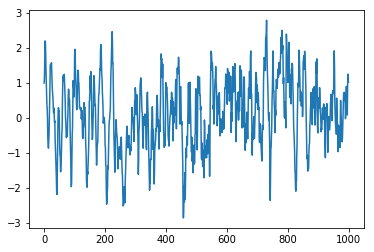

In [9]:
plt.plot(raw[:1000])

In [10]:
len(df)

800000

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.999627,0.569374,0.379649,1.191448,-0.210539,0.416294,0.877416,0.602209,0.232275,1.074389,...,0.355509,0.793437,0.213116,0.451905,0.367385,0.407253,0.128125,0.601219,0.611145,0.053217
1,1.200048,0.403209,0.274321,1.140876,-0.262827,0.219562,0.486908,0.210160,0.159672,1.379840,...,0.309329,0.854241,0.129892,0.495766,0.585260,0.347147,0.396399,0.956391,0.405673,0.038956
2,1.656269,0.407700,0.371290,1.481575,-0.165223,0.297512,0.540083,0.287658,0.188375,1.691790,...,0.522467,1.092095,0.224400,0.507575,0.624718,0.451947,0.408256,1.309511,0.703858,0.071756
3,2.204789,0.603057,0.541822,1.912772,0.178133,0.752224,0.651420,0.422900,0.227210,2.021071,...,0.717844,1.380023,0.349941,0.656029,0.623003,0.547500,0.569813,1.785812,1.112295,0.200101
4,2.188967,0.802905,0.602010,2.109739,0.362883,0.839454,0.862460,0.517113,0.328517,2.289695,...,0.636141,1.519516,0.403543,0.718448,0.813429,0.655382,0.639476,1.781706,1.545790,0.252865


In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,...,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05,5.388450e+05
mean,4.937896e-17,5.866373e-17,-3.980130e-18,-5.499472e-17,-3.460401e-19,3.381323e-17,2.258017e-17,2.357482e-18,3.123117e-18,-3.485249e-17,...,-5.536476e-17,3.556404e-17,3.068061e-17,-1.787546e-17,-2.157744e-17,3.129752e-17,-2.779065e-17,-1.234165e-19,2.853878e-18,-3.672114e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.279350e+00,-4.765889e+00,-4.415307e+00,-5.390967e+00,-4.245412e+00,-4.208770e+00,-4.355396e+00,-4.634234e+00,-4.274199e+00,-4.865659e+00,...,-5.223396e+00,-5.079584e+00,-4.647704e+00,-4.841840e+00,-4.739815e+00,-5.039245e+00,-4.908311e+00,-5.118498e+00,-5.811098e+00,-4.860979e+00
25%,-6.591202e-01,-6.656403e-01,-6.686204e-01,-6.611037e-01,-6.706716e-01,-6.750131e-01,-6.713234e-01,-6.696718e-01,-6.710458e-01,-6.629990e-01,...,-6.551239e-01,-6.623000e-01,-6.656685e-01,-6.581285e-01,-6.636619e-01,-6.607784e-01,-6.574289e-01,-6.634421e-01,-6.542599e-01,-6.583859e-01
50%,5.433442e-03,-1.220519e-02,-1.324274e-02,-3.660735e-03,-6.616865e-03,-1.428964e-02,-1.161353e-02,-1.625616e-02,-1.761558e-02,-1.052636e-04,...,-1.926021e-02,-2.389932e-03,-1.962804e-02,-2.382384e-02,-1.346746e-02,-1.656895e-02,-1.119993e-02,-2.369334e-03,-5.270071e-03,-1.808588e-02
75%,6.647128e-01,6.479663e-01,6.471505e-01,6.564440e-01,6.591808e-01,6.557136e-01,6.480963e-01,6.447574e-01,6.476338e-01,6.671212e-01,...,6.343650e-01,6.610969e-01,6.419287e-01,6.324116e-01,6.487358e-01,6.461346e-01,6.483686e-01,6.628095e-01,6.512370e-01,6.364747e-01
max,5.261209e+00,5.136684e+00,4.764995e+00,4.646351e+00,4.397757e+00,4.855762e+00,4.382021e+00,4.884362e+00,4.944740e+00,4.624987e+00,...,5.325192e+00,5.124879e+00,4.941342e+00,5.114719e+00,4.762631e+00,4.884355e+00,4.736211e+00,4.953623e+00,5.021269e+00,4.975969e+00


In [13]:
mse = nn.MSELoss()

#mean absolute error
L1 = nn.L1Loss()

def RMSELoss(yhat,y):
    return torch.sqrt(mse(yhat, y))

def MAELoss(yhat, y):
    return L1(yhat, y)

In [14]:
columns = df.columns

In [15]:
num_forward = 10
num_back = 100
y_index = 0
num_preds = 10

In [16]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [17]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, data_input, num_forward, y_index, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.y_index = y_index
        self.num_forward = num_forward
        self.copy_new.append("num_forward")
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("y_index")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i : i + self.num_back, :])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        i = self.items[i]
        return torch.Tensor(self.data_input[i + self.num_back : i + self.num_back + self.num_forward, self.y_index])

In [18]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            #nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            #nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            #nn.Linear(1280, 640),
            nn.Linear(3200, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [19]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[col] for col in columns], axis = -1)
#data_input = np.stack((df["0"], df["4"], df["22"], df["57"]), axis = -1)

In [20]:
data_input.shape

(800000, 64)

In [21]:
def usable(i):
    important = data_input[i - (30) : i + (num_back + num_preds)]
    return not np.isnan(np.sum(important))

In [190]:
indexes = [i for i in range(len(data_input) - num_back - num_preds) if usable(i)]

In [23]:
len(indexes)

530652

In [24]:
num_vars = 64

In [193]:
train_data = (TimeWindowList(indexes, num_back, data_input, num_forward, y_index)
            .split_by_idx(range(250000))
            .label_from_func(lambda x: x)
            .databunch(bs = 128, num_workers = 0))

In [26]:
learn = Learner(train_data, CNNModel(10, num_vars), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [27]:
#learn.save("CNN-forecast-exp-all")
learn.load("CNN-forecast-exp-all")

Learner(data=DataBunch;

Train: LabelList (280652 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([-0.4930, -0.2530, -0.1976, -0.1765,  0.0397,  0.1347,  0.2507,  0.0635,
        -0.4719, -0.6881]),tensor([-0.2530, -0.1976, -0.1765,  0.0397,  0.1347,  0.2507,  0.0635, -0.4719,
        -0.6881, -0.8543]),tensor([-0.1976, -0.1765,  0.0397,  0.1347,  0.2507,  0.0635, -0.4719, -0.6881,
        -0.8543, -1.0600]),tensor([-0.1765,  0.0397,  0.1347,  0.2507,  0.0635, -0.4719, -0.6881, -0.8543,
        -1.0600, -1.4582]),tensor([ 0.0397,  0.1347,  0.2507,  0.0635, -0.4719, -0.6881, -0.8543, -1.0600,
        -1.4582, -1.7509])
Path: .;

Valid: LabelList (250000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([1.8039, 1.9648, 1.7222, 1.2607, 1.0524, 0.8519, 0.4063, 0.2375, 0.5223,
        0.6964]),ten

# GradCAM Code

In [93]:
relu = nn.ReLU()

In [28]:
from fastai.callbacks.hooks import *

In [29]:
m = learn.model.eval().cuda()

In [30]:
m

CNNModel(
  (convs_2d): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convs_1d): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.

In [62]:
#runs the given xb through the model and hooks the activations and the gradients.
def hooked_backward(trues, xb, layer, pred_num = None):
    with hook_output(layer) as hook_a: 
        with hook_output(layer, grad=True) as hook_g:
            preds = m(xb)
            if pred_num == None:
                RMSELoss(preds, trues).backward()
            else:
                torch.abs(torch.sub(preds[0][pred_num], trues[0][pred_num])).backward()
    return hook_a,hook_g

In [63]:
#Returns the grad_cam at the given layer on the given item (x value)
def get_grad_cam_features(data, item, layer, m, y_actual = True, pred_num = None):
    y = item[1][None].cuda()
    if not y_actual:
        y = get_pred(item, data)
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb, layer, pred_num = pred_num)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    
    return np.transpose((acts*grad_chan[...,None,None]).mean(0))

In [64]:
#Makes each row in the array percents of the row sum.
def percentize(features):
    for i in range(len(features)):
        features[i] = np.array([features[i][j] / features[i].max() for j in range(len(features[i]))])
        
    return features

In [65]:
#Returns the models prediction on the given item.
def get_pred(item, data):
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    return m(xb)

In [66]:
#Draws the given x with the given heat map over it.
def draw_map(x, heat_map, save = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.plot(x)

    # Get second axis
    ax2 = ax.twinx()
    plt.imshow(np.repeat(heat_map[None], 100, 0), alpha = 0.6)
    plt.colorbar()
    plt.show()
    if save != None:
        fig.savefig(path/"ims"/save)

In [67]:
def d_m(x, heat_map, save = None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    for ax in axs.flat:
        im = ax.imshow(np.repeat(heat_map[None], 100, 0), alpha = 0.6, interpolation='bilinear', vmin = 0, vmax = 100)
        ax2 = ax.twinx()
        ax2.plot(x)
    fig.colorbar(im, ax=axs, shrink=0.6)
    plt.plot()

In [68]:
#Plots the average x from the items and grad cam results from the gs.
def plot_avg_var_map(var, items, gs, targ, save = None):
    total = []
    for piece in items:
        if int(piece[1]) == targ:
            total.append(np.array(piece[0].data[0][:,var]))
    total = np.array(total)
    x = total.mean(0)
    d_m(x, gs.mean(0)[var], save = save)

In [69]:
def get_avg_var_map(var, items, gs, targ, save = None):
    total = []
    for piece in items:
        if int(piece[1]) == targ:
            total.append(np.array(piece[0].data[0][:,var]))
    total = np.array(total)
    x = total.mean(0)
    return [x, np.repeat(gs.mean(0)[var], 40 // gs.shape[2])]

In [70]:
def draw_variable(item, g, var):
    x = item[0].data[0][:, var]
    draw_map(x, g[var])

In [71]:
#Gets the grad_cams for each piece of the data's validation set.
#Split into grad cams for above and not above data.
# def get_grad_cams(data):
#     f_res = []
#     t_res = []
#     for item in data.valid_ds:
#         g = get_grad_cam(data, item, m.convs_2d[5], m, y_actual = False)
#         g = relu(g)
#         if get_pred(item) == 0:
#             f_res.append(np.array(g))
#         else:
#             t_res.append(np.array(g))
#     return np.array(f_res), np.array(t_res)

In [95]:
def get_grad_cams(data, layer, func, ab, num = 10000000, pred_num = None):
    res = []
    count = 0
    if num < len(data.valid_ds):
        to_use = np.linspace(0, len(data.valid_ds)-1, num, dtype = "int")
    for item in data.valid_ds:
        if num > len(data.valid_ds) or count in to_use:
            g = func(data, item, layer, m, y_actual = True, pred_num = pred_num)
            #g = relu(g * -1)
            if ab:
                g = np.abs(g)
            else:
                g = relu(g * -1)
            res.append(np.array(g))
        count += 1
    return np.array(res)

In [73]:
#Returns variable importance for predicting false and predicting true.
def get_var_import(f_gs, t_gs):
    fs = []
    ts = []
    for g in f_gs:
        fs.append(list(g.mean(1)))
    for g in f_gs:
        ts.append(list(g.mean(1)))
    return np.array(fs).mean(0), np.array(ts).mean(0)

In [74]:
def get_most_imp(imps, num_most):
    imps = imps.copy()
    most_imp = []
    for i in range(num_most):
        tmp = imps.argmax()
        most_imp.append(tmp)
        imps[tmp] = 0
    
    return most_imp

In [75]:
#Returns the grad_cam at the given layer on the given item (x value)
def get_grad_cam_time(data, item, layer, m, y_actual = True, pred_num = None):
    y = item[1][None].cuda()
    if not y_actual:
        y = get_pred(item)
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb, layer, pred_num=pred_num)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1)
    
    return (acts*grad_chan[...,None]).mean(0)

# GradCAM

When using GradCAM on regression, there are a few different things I can think of to look at:
    
    1. Taking the gradient in reference to the RMSE loss function. This would mean that the GradCam plot would show how much each area contributed to decreasing the loss in a given sample.
    2. Taking the gradient in reference to the "loss" at a single time point. This would mean that the GradCam plot would show how much each are contributed to to decreasing the "loss" of a given time point in a given sample. The "loss" function here would probably just be the absolute value of subratcting y_hat from y_pred.
    3. Taking the gradient in reference to just the output at a single time point. This would mean that the GradCam plot would show how much each area contributed to either the increase or decrease of the prediction at a given time point in a given sample. In this case, the GradCAM would not be showing how the input affected the performance of the model on a prediction, instead it would just be showing what led to the output. I DO NOT SHOW THIS BELLOW, BUT WE CAN TRY IT LATER IF NECESSARY.

In [172]:
electrode_map = [[17,22,16,23,19,20,18,21],
[25,30,24,31,27,28,26,29],
[0, 9, 1, 8, 2, 6, 4, 5],
[10, 3, 12, 7, 13, 11, 14, 15],
[61,52,57,50,53,51,49,48],
[55,62,54,63,56,60,59,58],
[32,39,33,38,34,37,35,36],
[40,47,41,46,42,45,43,44]]

In [173]:
electrode_map = np.array(electrode_map)

In [221]:
#For bellow GradCAMs it is only on a subset of the samples with length 10000 because it takes a while to compute.
num = 10000
#These are the indexes of the dataset that will be used. It is evenly spaced throughout the entire length.
inds = np.linspace(0, len(train_data.valid_ds)-1, num, dtype = "int")

## RMSE Gradient

In [227]:
%%time
feat_gs = get_grad_cams(train_data, m.convs_2d[4], get_grad_cam_features, False, num = num, pred_num = None)

CPU times: user 11min 43s, sys: 19.1 s, total: 12min 2s
Wall time: 4min 15s


In [228]:
feat_gs.shape

(10000, 64, 50)

In [229]:
imps, _ = get_var_import(feat_gs, [])

In [230]:
imps = (imps / imps.sum()) * 100

In [231]:
importance_map = electrode_map.copy().astype(float)

In [232]:
for i in range(len(imps)):
    where = np.where(electrode_map == i)
    importance_map[where[0][0], where[1][0]] = imps[i]

This importance map shows the percent contribution to the GradCAM for each channel. The channels are placed in their actual physical location.

In [233]:
importance_map

array([[1.510195, 1.603515, 1.582183, 1.623241, 1.487126, 1.462596, 1.492229, 1.492705],
       [1.738968, 1.667428, 1.74438 , 1.64085 , 1.514869, 1.514345, 1.506158, 1.493351],
       [1.825959, 1.687133, 1.728572, 1.557195, 1.535045, 1.498435, 1.562369, 1.519217],
       [1.756173, 1.765589, 1.616769, 1.493279, 1.502608, 1.599011, 1.520402, 1.594411],
       [1.67274 , 1.766701, 1.542578, 1.485381, 1.465266, 1.485288, 1.533544, 1.393541],
       [1.622628, 1.79624 , 1.582446, 1.467741, 1.473515, 1.472181, 1.468068, 1.527199],
       [1.584974, 1.760316, 1.565203, 1.498128, 1.416177, 1.455168, 1.422913, 1.451599],
       [1.635186, 1.514489, 1.703913, 1.542447, 1.449051, 1.464787, 1.450196, 1.494085]])

In [234]:
electrode_map

array([[17, 22, 16, 23, 19, 20, 18, 21],
       [25, 30, 24, 31, 27, 28, 26, 29],
       [ 0,  9,  1,  8,  2,  6,  4,  5],
       [10,  3, 12,  7, 13, 11, 14, 15],
       [61, 52, 57, 50, 53, 51, 49, 48],
       [55, 62, 54, 63, 56, 60, 59, 58],
       [32, 39, 33, 38, 34, 37, 35, 36],
       [40, 47, 41, 46, 42, 45, 43, 44]])

This plot helps to show how the importance of a channel relates to its distance from the main channel (0)

I think that the reason for the difference in importance being stronger between columns than rows has to do with this:

Silicon probes consisted of either eight (3 rats) or four (3 rats) shanks (inter-shank distance of 200 μm), each with 8 recording leads (de-insulated area, 144 μm2) separated by ∼20 μm dorsoventrally.

This would mean that the columns are separated by more space than the rows are

[]

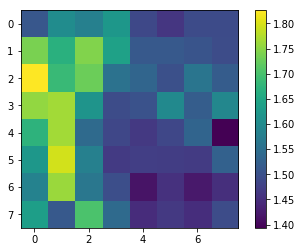

In [236]:
plt.imshow(importance_map)
plt.colorbar()
plt.plot()

[]

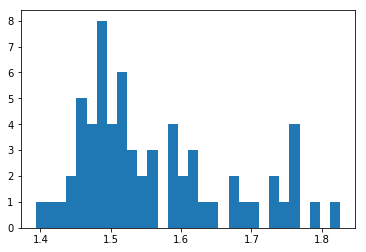

In [237]:
#Histogram of the channel importances
plt.hist(imps, bins = 30)
plt.plot()

0


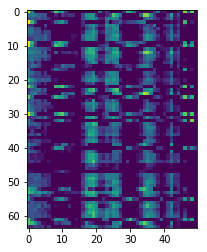

12501


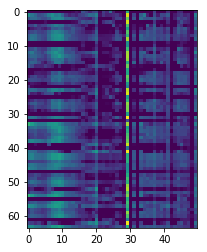

25002


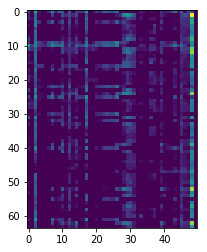

37503


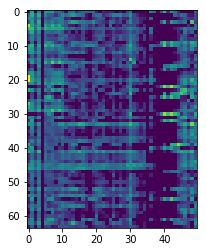

50004


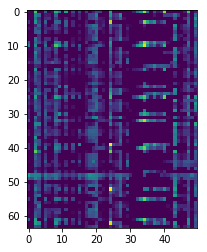

62506


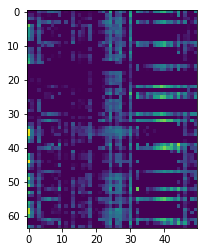

75007


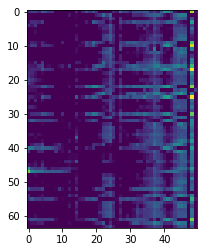

87508


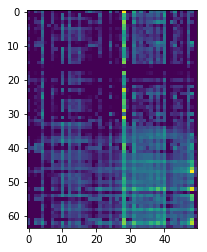

100009


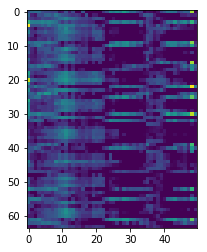

112510


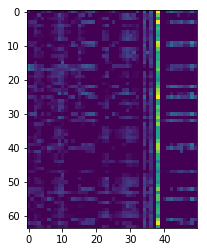

125012


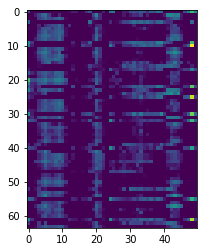

137513


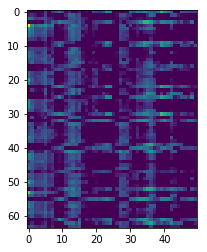

150014


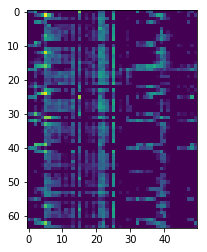

162515


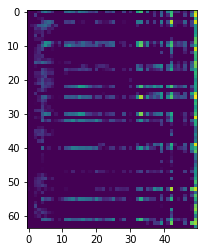

175016


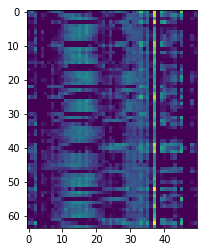

187518


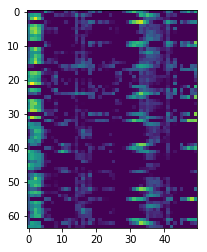

200019


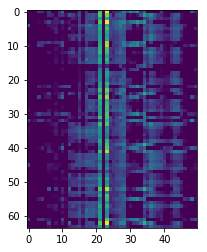

212520


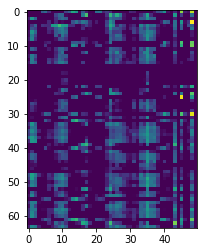

225021


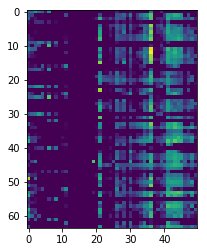

237522


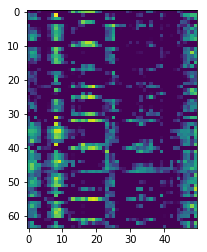

In [238]:
for i in range(0, num, num // 20):
    print(inds[i])
    #item = train_data.valid_ds[i]
    #print(RMSELoss(train_data.valid_ds[i][1][None], get_pred(item, train_data).cpu()))
    #print(feat_gs[i].max())
    plt.imshow(feat_gs[i])
    plt.show()

In [252]:
#draw_variable(train_data.valid_ds[inds[1]], np.repeat(feat_gs[1], 2, axis = 1), 0)

In [101]:
m.convs_1d

Sequential(
  (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4)
  (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
  (5): ReLU()
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4)
)

In [223]:
%%time
time_gs = get_grad_cams(train_data, m.convs_1d[5], get_grad_cam_time, False, pred_num = None, num = num)

CPU times: user 2min 38s, sys: 13.3 s, total: 2min 51s
Wall time: 2min 53s


In [224]:
time_gs.shape

(10000, 25)

In [225]:
time_gs.mean(0).shape

(25,)

Shows that overall usefulness decreased as time goes further back. Also shows that for some reason (probably because of the filter based nature of the CNN) the very end of the input is not used as much as just before the end.

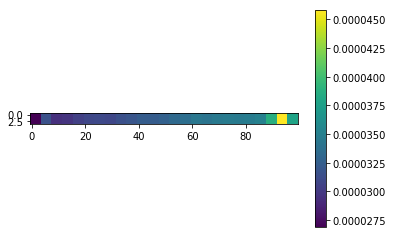

In [226]:
plt.imshow(np.repeat(np.repeat(time_gs.mean(0), 4)[None], 4, 0))
plt.colorbar()

## Single Time Point Loss

In [247]:
%%time
gss = []
for i in range(0, 10, 3):
    gss.append(get_grad_cams(train_data, m.convs_2d[4], get_grad_cam_features, False, num = num, pred_num = i))

CPU times: user 29min 37s, sys: 1min 12s, total: 30min 50s
Wall time: 12min 19s


In [270]:
len(gss)

4

t+0



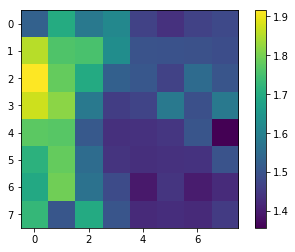

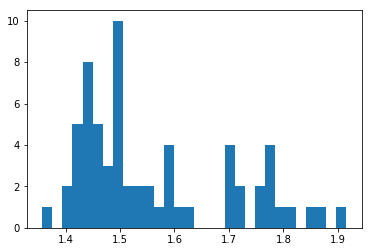

0


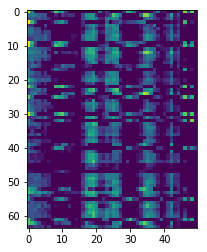

25002


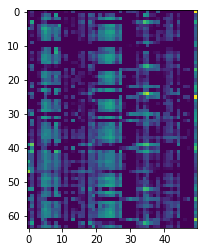

50004


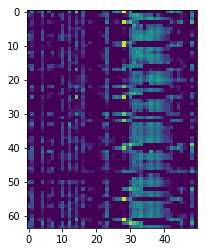

75007


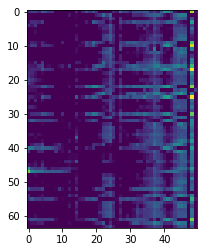

100009


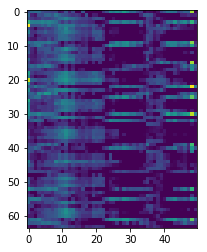

125012


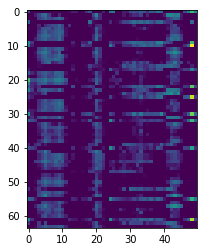

150014


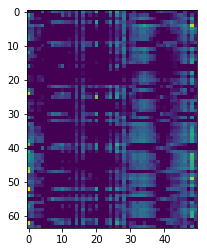

175016


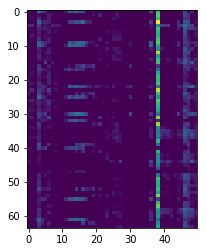

200019


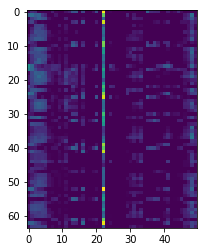

225021


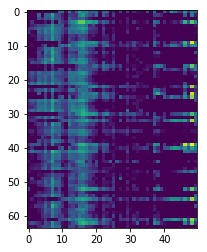

t+3



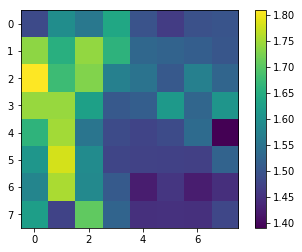

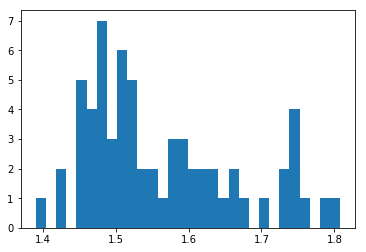

0


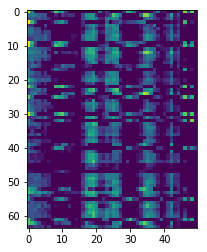

25002


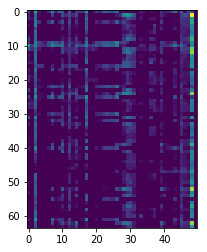

50004


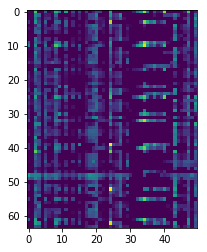

75007


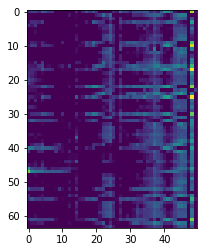

100009


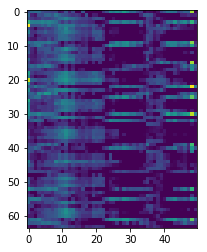

125012


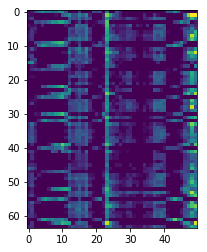

150014


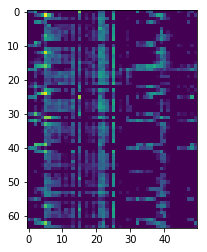

175016


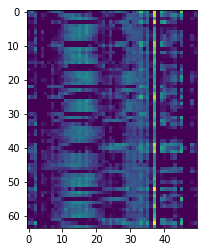

200019


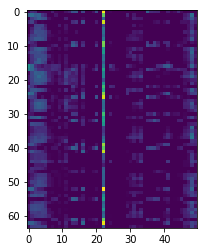

225021


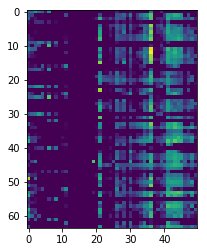

t+6



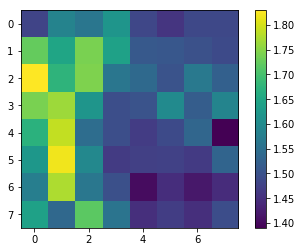

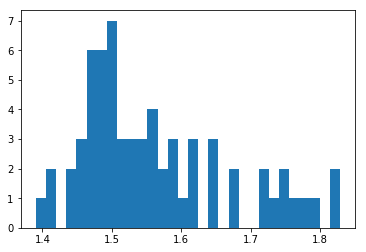

0


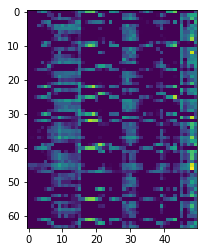

25002


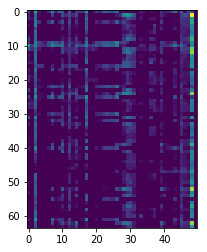

50004


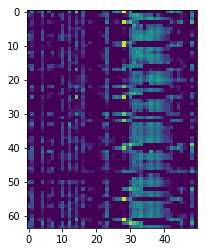

75007


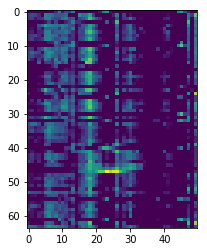

100009


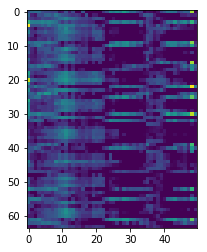

125012


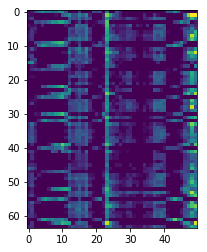

150014


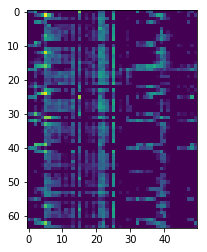

175016


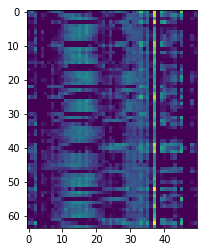

200019


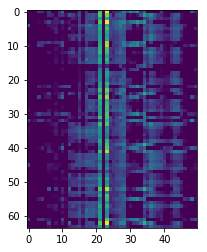

225021


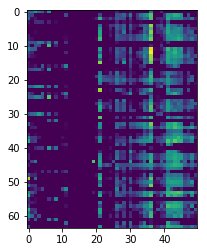

t+9



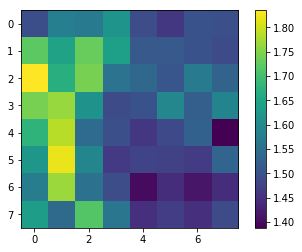

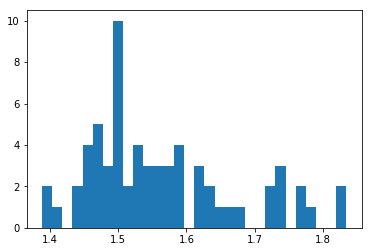

0


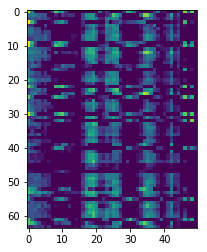

25002


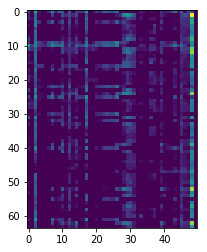

50004


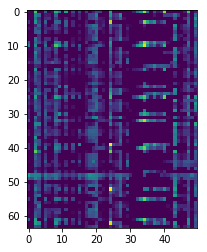

75007


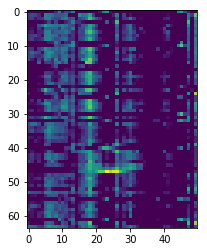

100009


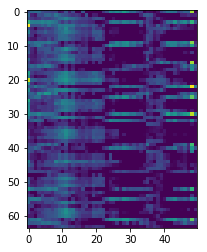

125012


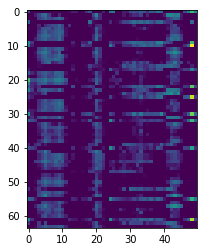

150014


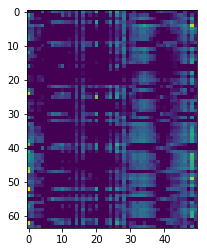

175016


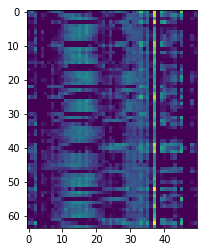

200019


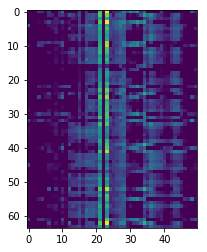

225021


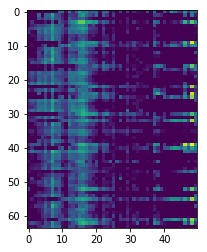

In [271]:
for i in range(len(gss)):
    gs = gss[i]
    
    print("t+"+ str(np.arange(0, 10, 3)[i]))
    print()
    
    imps, _ = get_var_import(gs, [])

    imps = (imps / imps.sum()) * 100

    importance_map = electrode_map.copy().astype(float)

    for i in range(len(imps)):
        where = np.where(electrode_map == i)
        importance_map[where[0][0], where[1][0]] = imps[i]
        
    plt.imshow(importance_map)
    plt.colorbar()
    plt.show()

    #Histogram of the channel importances
    plt.hist(imps, bins = 30)
    plt.show()

    for i in range(0, num, num // 10):
        print(inds[i])
        plt.imshow(gs[i])
        plt.show()

In [272]:
%%time
time_gss = []
for i in range(0, 10, 3):
    time_gss.append(get_grad_cams(train_data, m.convs_1d[5], get_grad_cam_time, False, pred_num = i, num = num))

CPU times: user 10min 23s, sys: 54.6 s, total: 11min 18s
Wall time: 11min 24s


t+0


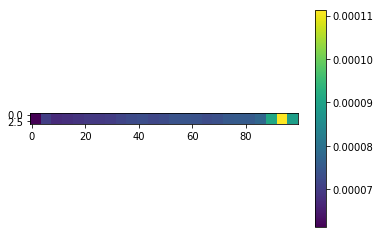

t+3


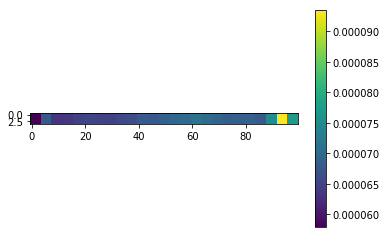

t+6


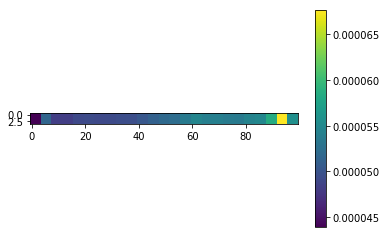

t+9


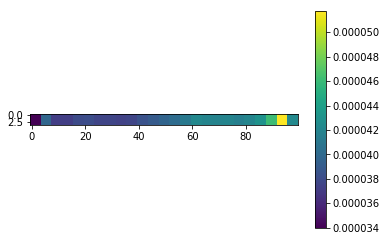

In [273]:
for i in range(len(time_gss)):
    print("t+"+ str(np.arange(0, 10, 3)[i]))
    plt.imshow(np.repeat(np.repeat(time_gss[i].mean(0), 4)[None], 4, 0))
    plt.colorbar()
    plt.show()